In [0]:
# import the libraries

import numpy as np
import random
from __future__ import division
import matplotlib.pyplot as plt
import math
pi = math.pi
import seaborn as sns

In [10]:
#link the google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Functions used to generate a matrix template for the toric code, apply errors
#and perform belief propagation. Other functions used to succesfully
#perform error decoding simulations or to complement the previous functions are
#included too.
def initial(L, verbose=False):
    '''
    Generates the initial code, for the X and Z components and the initial 
    syndromes,it also generates the initial error maps
    returns:2*L x 2*L array (code),2*L x 2*L array (code),2*L x 2*L array (code),
    L x L array (syndrome),L x L array (syndrome)
    '''
    code = np.zeros((2*L,2*L))
    code[::2,1::2] = 1
    code[1::2,::2] = 1#The code is generated to resemble the toric code
    codeX = 1*code
    codeZ = 1*code
    syndromeX = np.ones((L,L))
    syndromeZ = np.ones((L,L))
    if verbose==True:
        print code
    return code, codeX,codeZ,syndromeX,syndromeZ

def applyerror(codeX,codeZ,synX,synZ,i,j,error):
    '''
    For a qubit in a given position [i,j],it applies an error type 'error' in 
    the code 'code' and in the syndrome 'syn'
    arg: 2L X 2L code,2L X 2L code, L x L syndrome,L x L syndrome, position, string indicating type of error
    returns: 2L X 2L array(code), L x L array (syndrome),2L X 2L array(code), L x L array (syndrome)
    '''
    L = np.shape(codeX)[0]//2
    if error == 'X' or error == 'Y':#Since the position of the qubits are different depending 
    #on if the row number is even or odd,both cases need to be coded separately
        codeX[i,j]=-codeX[i,j]
        if i%2==0:
            synZ[((i-1)//2)%L,     j//2] = -synZ[((i-1)//2)    %L,j//2]
            synZ[(((i-1)//2)+1)%L, j//2] = -synZ[(((i-1)//2)+1)%L,j//2]
        if i%2==1:
            synZ[i//2, ((j-1)//2)    %L] = -synZ[i//2,((j-1)//2)    %L]
            synZ[i//2,(((j-1)//2)+1) %L] = -synZ[i//2,(((j-1)//2)+1)%L]
    if error == 'Z' or error == 'Y':
        codeZ[i,j]=-codeZ[i,j]
        if i%2==0:
            synX[i//2, ((j-1)//2)    %L] = -synX[i//2,((j-1)//2)    %L]
            synX[i//2,(((j-1)//2)+1) %L] = -synX[i//2,(((j-1)//2)+1)%L]
        if i%2==1:
            synX[ ((i-1)//2)   %L, j//2]  = -synX[((i-1)//2)    %L,j//2]
            synX[(((i-1)//2)+1)%L, j//2]  = -synX[(((i-1)//2)+1)%L,j//2]
    return [codeX,codeZ,synX,synZ]

def syndrome(code,syntype):
    '''
    Obtains the syndrome from a code
    Arg: 2L x 2L array (code), string (syndrome type)
    Returns: L x L array (syndrome)
    '''
    global L
    syn = np.ones((L,L))
    for i in range(L):
        for j in range(L):
            step = 1
            if syntype=='Z':#Depending on the type of error, each syndrome is
                        #determined by a different set of qubits
                step = code[(2*i)  %(2*L),(1+2*j)%(2*L)]*step
                step = code[(2*i+1)%(2*L),    2*j%(2*L)]*step
                step = code[(2*i+1)%(2*L),(2+2*j)%(2*L)]*step
                step = code[(2*i+2)%(2*L),(2*j+1)%(2*L)]*step
            if syntype=='X':
                step = code[(2*i)  %(2*L),(2*j+1)%(2*L)]*step
                step = code[(2*i+1)%(2*L),    2*j%(2*L)]*step
                step = code[(2*i-1)%(2*L),    2*j%(2*L)]*step
                step = code[(2*i)  %(2*L),(2*j-1)%(2*L)]*step
            syn[i,j] = step
    return syn  
  
def sigma(x):
    '''
    Performs the Fermi function on x
    arg: float or array of floats
    returns: float or array of floats depending on the type of the input
    '''
    sigma = 1/(np.exp(x)+1)
    return sigma

def asigma(x):
    '''
    Obtains x from a Fermi function on x
    arg: float or array of floats
    returns: float or array of floats depending on the type of the input
    '''
    asigma = np.log(1/x - 1)
    asigma[::2,::2] = 0
    asigma[1::2,1::2] = 0
    return asigma

def Beliefpropagation(p_err,code,syndrome,syntype,cycles):
    '''
    Performs Belief propagation on the code by using the syndromes given 
    and the probabilty of error. For this function it is assumed that the 
    probability of error is the same for all the qubits and for all types of
    error.
    
    arg: float (probability of error happening), 2L x 2L array (Code),
    L x L array (syndrome), string indicating type of error, integer
    returns: L x L array(belief for syndromes), 2L x 2L array (belief for errors),
    2L x 2L array (code)
    '''
    L = np.shape(code)[0]//2
    l = np.log10((1-p_err)/p_err)#The prior belief for the errors is calculated
    mu_e_s = np.zeros((2*L,2*L,2))#The messages for error to syndrome is generated
    #and with an initial condition that all elements are equal to 0
    mu_s_e = np.zeros((L,L,4))#The bmessages for syndrome to error is generated
    #and with an initial condition that all elements are equal to 0
    pred  = np.zeros((2*L,2*L))
    check = np.zeros((2*L,2*L),dtype=int)#A matrix which keeps track of which qubits
    #have been used
    mu_e = np.zeros((2*L,2*L))#The error belief for the last layer of the Belief
    #propagation algorithm
    for t in range(cycles):
        check = np.zeros((2*L,2*L),dtype=int)
        for i in range(L):#Each cycle is divided in two processes, the first one
          #obtains the belief from the syndrome to the errors by using the belief
          #from the errors to the syndrome
            for j in range(L):
                for it in range(4):#Depending on the qubit, we will use a different
                  #set of qubits to calculate the syndrome belief
                    step = 1
                    if syntype=='Z':#Depending on the type of error, each syndrome is
                      #determined by a different set of qubits
                        if it!=0:
                            step = np.tanh((mu_e_s[(2*i)  %(2*L),(1+2*j)%(2*L),
                                                   check[(2*i)  %(2*L),(1+2*j)%(2*L)]])/2)*step
                            
                        if it!=3:
                            step = np.tanh((mu_e_s[(2*i+1)%(2*L),    2*j%(2*L),
                                                   check[(2*i+1)%(2*L),    2*j%(2*L)]])/2)*step
                            
                        if it!=1:
                            step = np.tanh((mu_e_s[(2*i+1)%(2*L),(2+2*j)%(2*L),
                                                   check[(2*i+1)%(2*L),(2+2*j)%(2*L)]])/2)*step
                            
                        if it!=2:
                            step = np.tanh((mu_e_s[(2*i+2)%(2*L),(2*j+1)%(2*L),
                                                   check[(2*i+2)%(2*L),(2*j+1)%(2*L)]])/2)*step
                            
                    if syntype=='X':
                        if it!=1:
                            step = np.tanh((mu_e_s[(2*i)  %(2*L),(2*j+1)%(2*L),
                                                   check[(2*i)  %(2*L),(2*j+1)%(2*L)]])/2)*step
                            
                        if it!=2:
                            step = np.tanh((mu_e_s[(2*i+1)%(2*L),    2*j%(2*L),
                                                   check[(2*i+1)%(2*L),    2*j%(2*L)]])/2)*step
                            
                        if it!=0:
                            step = np.tanh((mu_e_s[(2*i-1)%(2*L),    2*j%(2*L),
                                                   check[(2*i-1)%(2*L),    2*j%(2*L)]])/2)*step
                            
                        if it!=3:
                            step = np.tanh((mu_e_s[(2*i)  %(2*L),(2*j-1)%(2*L),
                                                   check[(2*i)  %(2*L),(2*j-1)%(2*L)]])/2)*step
                            
                    mu_s_e[i,j,it] = (-1)**(1//2 - syndrome[i,j]//2)*2*np.arctanh(step)
                if syntype=='Z':#After each qubit, we mark them as used so the
                  #next time the same qubit is used, the components from the other
                  #syndrome are used
                    check[(2*i)  %(2*L),(1+2*j)%(2*L)] = 1
                    check[(2*i+1)%(2*L),    2*j%(2*L)] = 1
                    check[(2*i+1)%(2*L),(2+2*j)%(2*L)] = 1
                    check[(2*i+2)%(2*L),(2*j+1)%(2*L)] = 1
                if syntype=='X':
                    check[(2*i)  %(2*L),(2*j+1)%(2*L)] = 1
                    check[(2*i+1)%(2*L),    2*j%(2*L)] = 1 
                    check[(2*i-1)%(2*L),    2*j%(2*L)] = 1
                    check[(2*i)  %(2*L),(2*j-1)%(2*L)] = 1
        for i in range(2*L):
            for j in range(2*L):#The second one obtains the belief from 
              #the errors to the syndrome by using the belief
              #from the syndromes to the errors.
                if code[i,j]!=0:
                    if syntype=='Z':#Depending on the type of error, each map
                      #of qubits is determined by a different set of elements 
                      #of the syndrome
                        if i%2==0:
                            mu_e_s[i,j,1] = mu_s_e[  ((i-1)//2)  %L, j//2,2] + l
                            mu_e_s[i,j,0] = mu_s_e[(((i-1)//2)+1)%L, j//2,0] + l
                        if i%2==1:
                            mu_e_s[i,j,1] = mu_s_e[i//2 , ((j-1)//2)   %L,1] + l
                            mu_e_s[i,j,0] = mu_s_e[i//2,(((j-1)//2)+1) %L,3] + l
                    if syntype=='X':
                        if i%2==0:
                            mu_e_s[i,j,0] = mu_s_e[i//2 ,((j-1)//2)    %L,1] + l
                            mu_e_s[i,j,1] = mu_s_e[i//2,(((j-1)//2)+1) %L,3] + l
                        if i%2==1:
                            mu_e_s[i,j,0] = mu_s_e[ ((i-1)//2)   %L, j//2,2] + l
                            mu_e_s[i,j,1] = mu_s_e[(((i-1)//2)+1)%L, j//2,0] + l
    if t == (cycles-1):#For the last layer, we will sum all the combinations of
      #the syndrome to error message to obtain the final error belief
        for i in range(2*L):
            for j in range(2*L):
                if code[i,j] != 0:
                    mu_e[i,j] = l
                    if syntype=='Z':#Depending on the type of error, each map
                      #of qubits is determined by a different set of elements 
                      #of the syndrome
                        if i%2==0:
                            mu_e[i,j] += mu_s_e[(((i-1)//2)+1) %L, j//2,0]
                            mu_e[i,j] += mu_s_e[  ((i-1)//2)   %L, j//2,2]
                        if i%2==1:
                            mu_e[i,j] += mu_s_e[i//2 ,(((j-1)//2)+1) %L,3]
                            mu_e[i,j] += mu_s_e[i//2 , ((j-1)//2)    %L,1]
                    if syntype=='X':
                        if i%2==0:
                            mu_e[i,j] += mu_s_e[i//2,(((j-1)//2)+1)%L,3]
                            mu_e[i,j] += mu_s_e[i//2,((j-1)//2)    %L,1] 
                        if i%2==1:
                            mu_e[i,j] += mu_s_e[(((i-1)//2)+1)%L, j//2,0] 
                            mu_e[i,j] += mu_s_e[ ((i-1)//2)   %L, j//2,2] 
    for i in range(2*L):
        for j in range(2*L):
            if code[i,j]!=0:
                #For predictions, we will assume that an error belief 
                #greater than one means that there is not an error on the 
                #considered qubit and that there is an error otherwise
                if mu_e[i,j] >= 1:
                    pred[i,j] =  1
                else:
                    pred[i,j] = -1
    return[mu_s_e,mu_e,pred]   
  
def paritycheck(L):
    '''
    Generates the parity check matrix for a toric code lattice of size LxL
    Arg: integer
    Returns: 2Lx2LxLxL array (For X errors),2Lx2LxLxL array (For Z errors)
    '''
    H =np.zeros((2*L,2*L,L,L))#Parity-check matrix H given by [i,j,k,l], coordinates for error [i,j],
    #coordinates for syndrome[k,l]
    HZ = 1*H#We generate H for Z errors and X syndromes
    HX = 1*H#We generate H for X errors and Z syndromes
    for i in range(2*L):
        for j in range(2*L):
            if code[i,j]!=0:#If an error at position [i,j] would imply a change in the 
    #syndrome, a value of one is assigned to the positions in the syndrome it changes.
    #Otherwise, it doesn't affect the other syndrome positions.
                if i%2==0:
                    HX[i,j, ((i-1)//2)%L,      j//2         ] = 1
                    HX[i,j, (((i-1)//2)+1)%L,  j//2         ] = 1
                    HZ[i,j, i//2,            ((j-1)//2)   %L] = 1
                    HZ[i,j, i//2,           (((j-1)//2)+1)%L] = 1
                if i%2==1:
                    HZ[i,j, ((i-1)//2)%L,      j//2         ] = 1
                    HZ[i,j, (((i-1)//2)+1)%L,  j//2         ] = 1
                    HX[i,j, i//2,            ((j-1)//2)   %L] = 1
                    HX[i,j, i//2,           (((j-1)//2)+1)%L] = 1
    return HX,HZ 
    
    

In [0]:
#Functions and module used to perform neural belief propagation
def neuralbeliefpropagation(p_err,code,syndrome,syntype,cycles,wandb):
    """
    Return the output of the network if p_err and syndrome is input for
    the number of cycles specified.
    It assumes that the weights and biases are periodic, so it only calculates
    the weights and biases contained in a L=2 toric code
    Arg: float, 2L x 2L array, LxL array, string, integer, list of arrays
    Returns:  L x L array(belief for syndromes), 2L x 2L array (belief for errors),
    2L x 2L array (code)
    """
    w = wandb['weight']
    b = wandb['bias']
    L = np.shape(code)[0]//2
    l = np.log10((1-p_err)/p_err)#The prior belief for the errors is calculated
    mu_e_s = np.zeros((2*L,2*L,2))#The messages for error to syndrome is generated
    #and with an initial condition that all elements are equal to 0
    mu_s_e = np.zeros((L,L,4))#The messages for syndrome to error is generated
    #and with an initial condition that all elements are equal to 0
    pred  = np.zeros((2*L,2*L))
    mu_e = np.zeros((2*L,2*L))
    for t in range(cycles):
        check = np.zeros((2*L,2*L),dtype=int) 
        for i in range(L):#Each cycle is divided in two processes, the first one
        #obtains the messages from the syndrome to the errors by using the messages 
        #from the errors to the syndrome
            for j in range(L):
                for it in range(4):
                    step = 1
                    if syntype=='Z':#Depending on the type of error, each message syndrome is
                    #determined by a different set of qubits
                        if it!=0:
                            step = np.tanh((mu_e_s[(2*i)  %(2*L),(1+2*j)%(2*L),check[(2*i)  %(2*L),(1+2*j)%(2*L)]])/2)*step
                        if it!=3:
                            step = np.tanh((mu_e_s[(2*i+1)%(2*L),    2*j%(2*L),check[(2*i+1)%(2*L),    2*j%(2*L)]])/2)*step
                        if it!=1:
                            step = np.tanh((mu_e_s[(2*i+1)%(2*L),(2+2*j)%(2*L),check[(2*i+1)%(2*L),(2+2*j)%(2*L)]])/2)*step
                        if it!=2:
                            step = np.tanh((mu_e_s[(2*i+2)%(2*L),(2*j+1)%(2*L),check[(2*i+2)%(2*L),(2*j+1)%(2*L)]])/2)*step
                    if syntype=='X':
                        if it!=1:
                            step = np.tanh((mu_e_s[(2*i)  %(2*L),(2*j+1)%(2*L),check[(2*i)  %(2*L),(2*j+1)%(2*L)]])/2)*step
                        if it!=2:
                            step = np.tanh((mu_e_s[(2*i+1)%(2*L),    2*j%(2*L),check[(2*i+1)%(2*L),    2*j%(2*L)]])/2)*step
                        if it!=0:
                            step = np.tanh((mu_e_s[(2*i-1)%(2*L),    2*j%(2*L),check[(2*i-1)%(2*L),    2*j%(2*L)]])/2)*step
                        if it!=3:
                            step = np.tanh((mu_e_s[(2*i)  %(2*L),(2*j-1)%(2*L),check[(2*i)  %(2*L),(2*j-1)%(2*L)]])/2)*step
                    mu_s_e[i,j,it] = (-1)**(1//2 - syndrome[i,j]//2)*2*np.arctanh(step)
                if syntype=='Z':#After each qubit, we mark them as used so the
                  #next time the same qubit is used, the components from the other
                  #syndrome are used
                    check[(2*i)  %(2*L),(1+2*j)%(2*L)] = 1
                    check[(2*i+1)%(2*L),    2*j%(2*L)] = 1
                    check[(2*i+1)%(2*L),(2+2*j)%(2*L)] = 1
                    check[(2*i+2)%(2*L),(2*j+1)%(2*L)] = 1
                if syntype=='X':
                    check[(2*i)  %(2*L),(2*j+1)%(2*L)] = 1
                    check[(2*i+1)%(2*L),    2*j%(2*L)] = 1 
                    check[(2*i-1)%(2*L),    2*j%(2*L)] = 1
                    check[(2*i)  %(2*L),(2*j-1)%(2*L)] = 1
        for i in range(2*L):
            for j in range(2*L):#The second one obtains the messages from 
            #the errors to the syndrome by using the belief
            #from the syndromes to the errors.
                if code[i,j]!=0:
                    if syntype=='Z':#Depending on the type of error, each map
                    #of qubits is determined by a different set of elements 
                    #of the syndrome
                        if i%2==0:
                            mu_e_s[i,j,1] = mu_s_e[ ((i-1)//2)   %L, j//2,2]*w[t][t,i%4,j%4,1]+ l*b[t][t,i%4,j%4]
                            mu_e_s[i,j,0] = mu_s_e[(((i-1)//2)+1)%L, j//2,0]*w[t][t,i%4,j%4,0]+ l*b[t][t,i%4,j%4]
                        if i%2==1:
                            mu_e_s[i,j,1] = mu_s_e[i//2 , ((j-1)//2)   %L,1]*w[t][t,i%4,j%4,1]+ l*b[t][t,i%4,j%4]
                            mu_e_s[i,j,0] = mu_s_e[i//2,(((j-1)//2)+1) %L,3]*w[t][t,i%4,j%4,0]+ l*b[t][t,i%4,j%4]
                    if syntype=='X':
                        if i%2==0:
                            mu_e_s[i,j,0] = mu_s_e[i//2 ,((j-1)//2)    %L,1]*w[t][t,i%4,j%4,0]+ l*b[t][t,i%4,j%4]
                            mu_e_s[i,j,1] = mu_s_e[i//2,(((j-1)//2)+1) %L,3]*w[t][t,i%4,j%4,1]+ l*b[t][t,i%4,j%4]
                        if i%2==1:
                            mu_e_s[i,j,0] =  mu_s_e[ ((i-1)//2)   %L,j//2,2]*w[t][t,i%4,j%4,0]+ l*b[t][t,i%4,j%4]
                            mu_e_s[i,j,1] = mu_s_e[(((i-1)//2)+1) %L,j//2,0]*w[t][t,i%4,j%4,1]+ l*b[t][t,i%4,j%4]
                            
        
    for i in range(2*L):
        for j in range(2*L):#This final step obtains the error belief from the
          #messages from the syndromes to the errors
            if code[i,j] != 0:
                        mu_e[i,j] = l*b[t][t,i%4,j%4]
                        if syntype=='Z':#Depending on the type of error, each map
                          #of qubits is determined by a different set of elements 
                          #of the syndrome
                            if i%2==0:
                                mu_e[i,j] += mu_s_e[(((i-1)//2)+1)%L, j//2,0]*w[t][t,i%4,j%4,0]
                                mu_e[i,j] += mu_s_e[ ((i-1)//2)   %L, j//2,2]*w[t][t,i%4,j%4,1]
                            if i%2==1:
                                mu_e[i,j] += mu_s_e[i//2,(((j-1)//2)+1) %L,3]*w[t][t,i%4,j%4,0]
                                mu_e[i,j] += mu_s_e[i//2, ((j-1)//2)    %L,1]*w[t][t,i%4,j%4,1]
                        if syntype=='X':
                            if i%2==0:
                                mu_e[i,j] += mu_s_e[i//2,(((j-1)//2)+1)%L,3]*w[t][t,i%4,j%4,1]
                                mu_e[i,j] += mu_s_e[i//2 ,((j-1)//2)   %L,1]*w[t][t,i%4,j%4,0] 
                            if i%2==1:
                                mu_e[i,j] += mu_s_e[(((i-1)//2)+1)%L, j//2,0]*w[t][t,i%4,j%4,1]  
                                mu_e[i,j] += mu_s_e[ ((i-1)//2)   %L, j//2,2]*w[t][t,i%4,j%4,0]
    for i in range(2*L):
        for j in range(2*L):
            if code[i,j]!=0:
                #For predictions, we will assume that an error belief 
                #greater than one means that there is not an error on the 
                #considered qubit and that there is an error otherwise
                if mu_e[i,j] >= 1:
                    pred[i,j] =  1
                else:
                    pred[i,j] = -1
    return[mu_s_e,mu_e,pred]   
  
"""
A module to implement the stochastic gradient descent learning
algorithm for a feedforward neural network, modified to do Belief propagation
on the toric code.  Gradients are calculated using backpropagation.
The code its not optimized and omits many desirable features.
"""
#### Libraries
# Standard library
import random

# Third-party libraries
import numpy as np

class Network(object):

    def __init__(self, sizes,data = False):
        """Generates the set of weights, biases and coefficients used
        Arg: list, list of lists
        Returns: len(sizes)x2Lx2L array,len(sizes)x2Lx2Lx2 array,len(sizes) array
        """
        global L
        self.num_layers = len(sizes)
        self.sizes = sizes
        if data==False:
            self.biases  = [np.ones((len(sizes),4,4))   for t in range(len(sizes))]
            self.weights = [np.ones((len(sizes),4,4,2)) for t in range(len(sizes))]
            self.coef = [1/len(sizes) for t in range(len(sizes))]
        else:
            wandb = np.load(data)
            self.weights = wandb['weight']
            self.biases  = wandb['bias']
            self.coef    = wandb['coef']

    def feedforward(self, p_err, syntype, syndrome,cycles,record = False):
        """
        Return the output of the network if p_err and syndrome is input for
        the number of cycles specified.
        Depends on the syntype and also the parameter record can be set to true
        to obtain the values of each layer of the network
        It assumes that the weights and biases are periodic, so it only calculates
        the weights and biases contained in a L=2 toric code
        Arg: float, string, LxL array, integer, boolean
        Returns: 2Lx2L array if record = False or 2*cyclesx2Lx2L array,
        cyclesx2Lx2L array and 2Lx2L array if record = True
        """
        b = self.biases
        w = self.weights
        L = np.shape(code)[0]//2
        l = np.log10((1-p_err)/p_err)#The prior belief for the errors is calculated
        mu_e_s = np.zeros((2*L,2*L,2))#The messages for error to syndrome is generated
        #and with an initial condition that all elements are equal to 0
        mu_s_e = np.zeros((L,L,4))#The messages for syndrome to error is generated
        #and with an initial condition that all elements are equal to 0
        pred  = np.zeros((2*L,2*L))
        zs = []
        activations = []
        mu_e = np.zeros((2*L,2*L))
        for t in range(cycles):
            check = np.zeros((2*L,2*L),dtype=int) 
            for i in range(L):#Each cycle is divided in three processes, the first one
              #obtains the messages from the syndrome to the errors by using the messages
              #from the errors to the syndrome
                for j in range(L):
                    for it in range(4):
                        step = 1
                        if syntype=='Z':#Depending on the type of error, each syndrome is
                          #determined by a different set of qubits
                            if it!=0:
                                step = np.tanh((mu_e_s[(2*i)  %(2*L),(1+2*j)%(2*L),check[(2*i)  %(2*L),(1+2*j)%(2*L)]])/2)*step
                            if it!=3:
                                step = np.tanh((mu_e_s[(2*i+1)%(2*L),    2*j%(2*L),check[(2*i+1)%(2*L),    2*j%(2*L)]])/2)*step
                            if it!=1:
                                step = np.tanh((mu_e_s[(2*i+1)%(2*L),(2+2*j)%(2*L),check[(2*i+1)%(2*L),(2+2*j)%(2*L)]])/2)*step
                            if it!=2:
                                step = np.tanh((mu_e_s[(2*i+2)%(2*L),(2*j+1)%(2*L),check[(2*i+2)%(2*L),(2*j+1)%(2*L)]])/2)*step
                        if syntype=='X':
                            if it!=1:
                                step = np.tanh((mu_e_s[(2*i)  %(2*L),(2*j+1)%(2*L),check[(2*i)  %(2*L),(2*j+1)%(2*L)]])/2)*step
                            if it!=2:
                                step = np.tanh((mu_e_s[(2*i+1)%(2*L),    2*j%(2*L),check[(2*i+1)%(2*L),    2*j%(2*L)]])/2)*step
                            if it!=0:
                                step = np.tanh((mu_e_s[(2*i-1)%(2*L),    2*j%(2*L),check[(2*i-1)%(2*L),    2*j%(2*L)]])/2)*step
                            if it!=3:
                                step = np.tanh((mu_e_s[(2*i)  %(2*L),(2*j-1)%(2*L),check[(2*i)  %(2*L),(2*j-1)%(2*L)]])/2)*step
                        mu_s_e[i,j,it] = (-1)**(1//2 - syndrome[i,j]//2)*2*np.arctanh(step)
                    if syntype=='Z':#After each qubit, we mark them as used so the
                  #next time the same qubit is used, the components from the other
                  #syndrome are used
                        check[(2*i)  %(2*L),(1+2*j)%(2*L)] = 1
                        check[(2*i+1)%(2*L),    2*j%(2*L)] = 1
                        check[(2*i+1)%(2*L),(2+2*j)%(2*L)] = 1
                        check[(2*i+2)%(2*L),(2*j+1)%(2*L)] = 1
                    if syntype=='X':
                        check[(2*i)  %(2*L),(2*j+1)%(2*L)] = 1
                        check[(2*i+1)%(2*L),    2*j%(2*L)] = 1 
                        check[(2*i-1)%(2*L),    2*j%(2*L)] = 1
                        check[(2*i)  %(2*L),(2*j-1)%(2*L)] = 1
            for i in range(2*L):
                    for j in range(2*L):#The second one obtains the messages from 
                      #the errors to the syndrome by using the messages
                      #from the syndromes to the errors.
                        if code[i,j]!=0:
                            if syntype=='Z':#Depending on the type of error, each map
                            #of qubits is determined by a different set of elements 
                            #of the syndrome
                                if i%2==0:
                                    mu_e_s[i,j,1] = mu_s_e[ ((i-1)//2)   %L, j//2,2]*w[t][t,i%4,j%4,1]+ l*b[t][t,i%4,j%4]
                                    mu_e_s[i,j,0] = mu_s_e[(((i-1)//2)+1)%L, j//2,0]*w[t][t,i%4,j%4,0]+ l*b[t][t,i%4,j%4]
                                if i%2==1:
                                    mu_e_s[i,j,1] = mu_s_e[i//2 , ((j-1)//2)   %L,1]*w[t][t,i%4,j%4,1]+ l*b[t][t,i%4,j%4]
                                    mu_e_s[i,j,0] = mu_s_e[i//2,(((j-1)//2)+1) %L,3]*w[t][t,i%4,j%4,0]+ l*b[t][t,i%4,j%4]
                            if syntype=='X':
                                if i%2==0:
                                    mu_e_s[i,j,0] = mu_s_e[i//2 ,((j-1)//2)    %L,1]*w[t][t,i%4,j%4,0]+ l*b[t][t,i%4,j%4]
                                    mu_e_s[i,j,1] = mu_s_e[i//2,(((j-1)//2)+1) %L,3]*w[t][t,i%4,j%4,1]+ l*b[t][t,i%4,j%4]
                                if i%2==1:
                                    mu_e_s[i,j,0] =  mu_s_e[ ((i-1)//2)   %L,j//2,2]*w[t][t,i%4,j%4,0]+ l*b[t][t,i%4,j%4]
                                    mu_e_s[i,j,1] = mu_s_e[(((i-1)//2)+1) %L,j//2,0]*w[t][t,i%4,j%4,1]+ l*b[t][t,i%4,j%4]
            zs.append(1*mu_s_e)
            for i in range(2*L):
                for j in range(2*L):#The last one obtains the error belief from
                  #the messages from the syndromes to the errors.
                    if code[i,j] != 0:
                        mu_e[i,j] = l*b[t][t,i%4,j%4]
                        if syntype=='Z':#Depending on the type of error, each map
                          #of qubits is determined by a different set of elements 
                          #of the syndrome
                            if i%2==0:
                                mu_e[i,j] += mu_s_e[(((i-1)//2)+1)%L, j//2,0]*w[t][t,i%4,j%4,0]
                                mu_e[i,j] += mu_s_e[ ((i-1)//2)   %L, j//2,2]*w[t][t,i%4,j%4,1]
                            if i%2==1:
                                mu_e[i,j] += mu_s_e[i//2,(((j-1)//2)+1) %L,3]*w[t][t,i%4,j%4,0]
                                mu_e[i,j] += mu_s_e[i//2, ((j-1)//2)    %L,1]*w[t][t,i%4,j%4,1]
                        if syntype=='X':
                            if i%2==0:
                                mu_e[i,j] += mu_s_e[i//2,(((j-1)//2)+1) %L,3]*w[t][t,i%4,j%4,1]
                                mu_e[i,j] += mu_s_e[i//2 ,((j-1)//2)    %L,1]*w[t][t,i%4,j%4,0] 
                            if i%2==1:
                                mu_e[i,j] += mu_s_e[(((i-1)//2)+1)%L, j//2,0]*w[t][t,i%4,j%4,1]  
                                mu_e[i,j] += mu_s_e[ ((i-1)//2)   %L, j//2,2]*w[t][t,i%4,j%4,0]
            zs.append(1*mu_e)
            activations.append(sigmoid(1*mu_e))
        if record == True: 
            return zs,activations,sigmoid(1*mu_e)
            
        if record == False:
            return sigmoid(mu_e)
    

    def SGD(self, training_data, epochs, mini_batch_size, eta,p_err,syntype,filepath,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in xrange(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in xrange(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta, p_err, syntype, mini_batch[0][0],12)
            np.savez(filepath,weight = self.weights, bias = self.biases, coef = self.coef)
            if test_data:
                print "Epoch {0}: {1} / {2}".format(
                    j, self.evaluate(test_data), n_test)
            else:
                print "Epoch {0} complete".format(j)

    def update_mini_batch(self, mini_batch, eta, p_err, syntype, syndrome,cycles):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        nabla_c = [0 for c in self.coef]
        for x, y in mini_batch:
            delta_nabla_c,delta_nabla_b, delta_nabla_w = self.backprop(x, y, p_err, syntype, syndrome,cycles,eta)
            nabla_b = map(sum,zip(nabla_b,delta_nabla_b))
            nabla_w = map(sum,zip(nabla_w,delta_nabla_w))
            nabla_c = map(sum,zip(nabla_c,delta_nabla_c))
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]
        self.coef = [c-(eta/len(mini_batch))*nc
                       for c, nc in zip(self.coef, nabla_c)]

    def backprop(self, x, y, p_err, syntype, syndrome,cycles,lr):
        """Return a tuple ``(nabla_b, nabla_w,nabla_c)`` representing the
        gradient for the cost function C_x.  ``nabla_b``,''nabla_c'' and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        nabla_c = [0 for c in self.coef]
        # feedforward
        activation = x
        activations = [x]
        zs,activations,pred = self.feedforward( p_err, syntype, syndrome,cycles,record = True)
        # Backwards pass
        for ind in xrange(0, (self.num_layers)):
            delta_w,delta_b,delta_c = delta(zs,y,p_err,2*ind,syntype,self.coef)
            nabla_w[ind]    = np.dot(delta_w,-lr)
            nabla_b[ind]    = np.dot(delta_b,-lr)
            nabla_c[ind]    = np.dot(delta_c,-lr)
        return (nabla_c,nabla_b, nabla_w)

    def evaluate(self, test_data,syntype,HZ,HX):#Loss function
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x, p_err, syntype, syndrome,cycles)), y)
                        for (x, y) in test_data]
        if syntype == 'Z':
            H = HX
        if syntype == 'X':
            H = HZ
        C = []
        for (x, y) in test_results:
            cost  = 0
            cost2 = 0
            for k in range(L):
                for l in range(L):
                    for i in range(2*L):
                        for j in range(2*L):
                            cost += H[i,j,k,l]*(y[i,j]+sigmoid(x[i,j]))
                    cost2 += abs(np.sin((pi*cost)/2))
            C.append(cost2)
        return C


#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

def delta(x,y,p_err,index,syntype,c):
  '''
  Obtains the derivative of the loss function with respect to the bias
  and the derivative of the loss function with respect to the weights.
  It assumes that the weights and biases are periodic, so it only calculates
  the weights and biases contained in a L=2 toric code
  Arg: 2Lx2L array for the error belief (mu_e),float,list of LxL arrays for
  the syndrome belief (mu_s_e),integer, len(sizes) array 
  Returns: list of length num_layers of arrays of size 2L**2 and 4L**2
  for the weights , list of length num_layers of arrays of size 2L**2 and 4L**2
  for the biases and list of length num_layers for the coefficients
  '''
  global L
  HX,HZ = paritycheck(L)#We generate the parity check matrices
  delta_b = np.zeros((4,4))
  delta_w = np.zeros((4,4,2))
  lb = np.log10((1-p_err)/p_err)
  if syntype == 'Z':#Depending on the syntype, we set the parity check matrix
      H = HX
  if syntype == 'X':
      H = HZ
  for i in range(4):
      for j in range(4):
          stepb = 0
          stepw1 = 0
          stepw2 = 0
          stepc = 0
          for k in range(2):
              for l in range(2):
                  step = 0
                  for m in range(4):
                      for n in range(4):#We calculate the term inside the sin and
                        #cos
                          step += H[m,n,k,l]*(y[m,n]+sigmoid(x[index+1][m,n]))*(pi/2)
                  if np.sin(step)<0:#Depending on the value of step, we apply a
                    #correction, as |sin(step)|
                      correc = -1
                  else:
                      correc = 1
                  #We sum for all the qubits the terms depending on the syndromes
                  #for the biases
                  stepb += (pi/2)*H[i,j,k,l]*sigmoid_prime(x[index+1][i,j])*lb*np.cos(step)*correc
                  #We sum all the terms for the coefficients
                  stepc += abs(np.sin(step))
                  if syntype=='Z':#We sum all the terms depending on the syndromes
                    #for the weights
                      if i%2==0:
                          stepw2 += (pi/2)*H[i,j,k,l]*sigmoid_prime(x[index+1][i,j])*x[index][  ((i-1)//2)  %L, j//2,2]*np.cos(step)*correc
                          stepw1 += (pi/2)*H[i,j,k,l]*sigmoid_prime(x[index+1][i,j])*x[index][(((i-1)//2)+1)%L, j//2,0]*np.cos(step)*correc
                      if i%2==1:
                          stepw2 += (pi/2)*H[i,j,k,l]*sigmoid_prime(x[index+1][i,j])*x[index][i//2 , ((j-1)//2)   %L,1]*np.cos(step)*correc
                          stepw1 += (pi/2)*H[i,j,k,l]*sigmoid_prime(x[index+1][i,j])*x[index][i//2,(((j-1)//2)+1) %L,3]*np.cos(step)*correc
                  if syntype=='X':
                      if i%2==0:
                          stepw2 += (pi/2)*H[i,j,k,l]*sigmoid_prime(x[index+1][i,j])*x[index][i//2 ,((j-1)//2)   %L, 1]*np.cos(step)*correc
                          stepw1 += (pi/2)*H[i,j,k,l]*sigmoid_prime(x[index+1][i,j])*x[index][i//2,(((j-1)//2)+1)%L, 3]*np.cos(step)*correc
                      if i%2==1:
                          stepw1 += (pi/2)*H[i,j,k,l]*sigmoid_prime(x[index+1][i,j])*x[index][ ((i-1)//2)   %L, j//2,2]*np.cos(step)*correc
                          stepw2 += (pi/2)*H[i,j,k,l]*sigmoid_prime(x[index+1][i,j])*x[index][(((i-1)//2)+1)%L, j//2,0]*np.cos(step)*correc
          if code[i,j]!=0:
              delta_w[i,j,0] = stepw1*c[index//2]
              delta_w[i,j,1] = stepw2*c[index//2]
              delta_b[i,j]   = stepb*c[index//2]
          delta_c = stepc
  return delta_w,delta_b,delta_c
  
  


In [0]:
#Syndrome and error mapping, given error 
L=3#The dimensions of the code given by the number of plaquettes
p_err = 0.01#The probability of having an error
code, codeX,codeZ,syndromeX,syndromeZ = initial(L)
print('Errorless code')
print(code)
[codeX,codeZ,syndromeX,syndromeZ]=applyerror(codeX,codeZ,syndromeX,syndromeZ,0,3,'Y')
[codeX,codeZ,syndromeX,syndromeZ]=applyerror(codeX,codeZ,syndromeX,syndromeZ,0,5,'Y')
# [codeX,codeZ,syndromeX,syndromeZ]=applyerror(codeX,codeZ,syndromeX,syndromeZ,0,1,'Y')
# [codeX,codeZ,syndromeX,syndromeZ]=applyerror(codeX,codeZ,syndromeX,syndromeZ,5,10,'Y')
# [codeX,codeZ,syndromeX,syndromeZ]=applyerror(codeX,codeZ,syndromeX,syndromeZ,7,10,'Y')
# [codeX,codeZ,syndromeX,syndromeZ]=applyerror(codeX,codeZ,syndromeX,syndromeZ,8,5,'Y')
# [codeX,codeZ,syndromeX,syndromeZ]=applyerror(codeX,codeZ,syndromeX,syndromeZ,8,7,'Y')
# [codeX,codeZ,syndromeX,syndromeZ]=applyerror(codeX,codeZ,syndromeX,syndromeZ,8,9,'Y')
# [codeX,codeZ,syndromeX,syndromeZ]=applyerror(codeX,codeZ,syndromeX,syndromeZ,5,4,'Y')
# [codeX,codeZ,syndromeX,syndromeZ]=applyerror(codeX,codeZ,syndromeX,syndromeZ,7,4,'Y')
print('Code Z')
print(codeZ)
print('Syndrome X')
print(syndromeX)

print('Code X')  
print(codeX)
print('Syndrome Z')
print(syndromeZ)

Errorless code
[[0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0.]]
Code Z
[[ 0.  1.  0. -1.  0. -1.]
 [ 1.  0.  1.  0.  1.  0.]
 [ 0.  1.  0.  1.  0.  1.]
 [ 1.  0.  1.  0.  1.  0.]
 [ 0.  1.  0.  1.  0.  1.]
 [ 1.  0.  1.  0.  1.  0.]]
Syndrome X
[[-1. -1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
Code X
[[ 0.  1.  0. -1.  0. -1.]
 [ 1.  0.  1.  0.  1.  0.]
 [ 0.  1.  0.  1.  0.  1.]
 [ 1.  0.  1.  0.  1.  0.]
 [ 0.  1.  0.  1.  0.  1.]
 [ 1.  0.  1.  0.  1.  0.]]
Syndrome Z
[[ 1. -1. -1.]
 [ 1.  1.  1.]
 [ 1. -1. -1.]]


In [6]:
#Syndrome and error mapping, random error
L=3#The dimensions of the code given by the number of plaquettes
p_err = 0.03#The probability of having an error
code, codeX,codeZ,syndromeX,syndromeZ = initial(L)
error_list = ['X','Y','Z']
print('Errorless code')
print(code)
for error in range(3):#For each type of error we generate random numbers to see if that qubit has that type of error or not
    for i in range(2*L):#For each qubit, we generate a random number, which if its smaller than p_err, we assign an error on that qubit
        for j in range(2*L):
            if code[i,j]!=0:
                prob = random.random()
                if prob <= p_err:#if prob is smaller than p_err, we assign an error
                    codeX,codeZ,syndromeX,syndromeZ=applyerror(codeX,codeZ,syndromeX,syndromeZ,i,j,error_list[error])
print('Code X')  
print(codeX)
print('Syndrome Z')
print(syndromeZ)
print('Code Z')
print(codeZ)
print('Syndrome X')
print(syndromeX)


Errorless code
[[0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0.]]
Code X
[[0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0.]]
Syndrome Z
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
Code Z
[[0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0.]]
Syndrome X
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


In [8]:
#Tanner graph
HX,HZ = paritycheck(L)
print('H for Z errors')
print(HZ[0,5,:,:])
print('H for X errors')
print(HX[:,:,1,0])

H for Z errors
[[1. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]]
H for X errors
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [9]:
#Belief propagation
[mu_s_e,mu_e_s,pred] = Beliefpropagation(p_err,code,syndromeZ,'Z',12)
# print('Syndrome Belief')
# print(mu_s_e)
# print('Error Belief')
# print(mu_e_s)
print('Error prediction')
print(pred)
print('Real error')
print(codeX)
print('Check')
print(np.array_equal(pred,codeX))

Error prediction
[[0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0.]]
Real error
[[0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0.]]
Check
True


In [0]:
#Neural Belief propagation
wandb = np.load('drive/My Drive/weightbias4X.npz')
[mu_s_e,mu_e_s,pred] = neuralbeliefpropagation(p_err,code,syndromeX,'X',12,wandb)
# print('Syndrome Belief')
# print(mu_s_e)
print('Error Belief')
print(mu_e_s)
print('Error prediction')
print(pred)
print('Real error')
print(codeZ)
print('Check')
print(np.array_equal(pred,codeZ))

('L = ', 4, ' for p_err = ', 0.01)
('L = ', 4, ' for p_err = ', 0.015)
('L = ', 4, ' for p_err = ', 0.02)
('L = ', 4, ' for p_err = ', 0.025)
('L = ', 4, ' for p_err = ', 0.03)
('L = ', 4, ' for p_err = ', 0.035)
('L = ', 4, ' for p_err = ', 0.04)
('L = ', 4, ' for p_err = ', 0.045000000000000005)
('L = ', 4, ' for p_err = ', 0.05)
('L = ', 4, ' for p_err = ', 0.055)
('L = ', 4, ' for p_err = ', 0.060000000000000005)
('L = ', 4, ' for p_err = ', 0.065)
('L = ', 4, ' for p_err = ', 0.06999999999999999)
('L = ', 4, ' for p_err = ', 0.075)
('L = ', 4, ' for p_err = ', 0.08)
('L = ', 4, ' for p_err = ', 0.08499999999999999)
('L = ', 4, ' for p_err = ', 0.09)
('L = ', 4, ' for p_err = ', 0.095)
('L = ', 4, ' for p_err = ', 0.09999999999999999)
('L = ', 4, ' for p_err = ', 0.105)
('L = ', 6, ' for p_err = ', 0.01)
('L = ', 6, ' for p_err = ', 0.015)
('L = ', 6, ' for p_err = ', 0.02)
('L = ', 6, ' for p_err = ', 0.025)
('L = ', 6, ' for p_err = ', 0.03)
('L = ', 6, ' for p_err = ', 0.035)
('

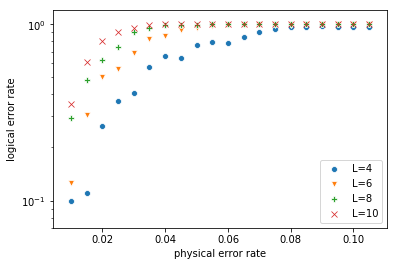

In [0]:
#Evolution of the logical error rate where each qubit has a p_err probability of having an error
error_list = ['X','Y','Z']#We generate a list with each type of error tag
LER = []#We generate a list where we will save each logical error rate
FLER  = []
UFLER = []
iterations = 100
for l in range(8):
    L = 4 +2*l#We obtain the lattice size L
    n = 2*(L**2)#We obtain the number of physical qubits
    LER.append([])#We add a sublist for each size of L
    FLER.append([])
    UFLER.append([])
    for r in range(20):
        p_err = 0.005*r+0.01#We obtain the probability of error p_err
        itcounter = 0
        fcounter  = 0
        ufcounter = 0
        for r in range(iterations):
            code, codeX,codeZ,syndromeX,syndromeZ = initial(L)#We generate the initial conditions
            checkZ = np.zeros((2*L,2*L))
            checkX = np.zeros((2*L,2*L))
            for error in range(3):#For each type of error we generate random numbers to see if that qubit has that type of error or not
                for i in range(2*L):#For each qubit, we generate a random number, which if its smaller than p_err, we assign an error on that qubit
                    for j in range(2*L):
                        if code[i,j]!=0:
                            prob = random.random()
                            if prob <= p_err:
                                codeX,codeZ,syndromeX,syndromeZ=applyerror(codeX,codeZ,syndromeX,syndromeZ,i,j,error_list[error])
            [mu_s_e,mu_e_s,predX] = Beliefpropagation(p_err,code,syndromeX,'X',12)#Once we have the code with errors, we try to obtain them using Belief propagation
            [mu_s_e,mu_e_s,predZ] = Beliefpropagation(p_err,code,syndromeZ,'Z',12)
            for i in range(2*L):
                for j in range(2*L):
                    checkZ[i,j] = predX[i,j]*codeZ[i,j]
                    checkX[i,j] = predZ[i,j]*codeX[i,j]
            if np.all(syndrome(checkZ,'Z')==1)==True:
                if np.any(checkZ==-1)==True:
                    itcounter += 1
                    ufcounter += 1
            if np.all(syndrome(checkZ,'Z')==1)==False:
                itcounter += 1
                fcounter  += 1
            if np.all(syndrome(checkX,'X')==1)==True:
                if np.any(checkX==-1)==True:
                    itcounter += 1
                    ufcounter += 1
            if np.all(syndrome(checkX,'X')==1)==False:
                itcounter += 1
                fcounter  += 1
        LER[l].append(itcounter/(2*iterations))
        print('L = ',L,' for p_err = ',p_err)
        FLER[l].append(fcounter/(2*iterations))
        UFLER[l].append(ufcounter/(2*iterations))
perr = np.arange(0.01,0.11,0.005)
sns.scatterplot(perr,LER[0],label = 'L=4',marker = 'o')
sns.scatterplot(perr,LER[1],label = 'L=6',marker = 'v')
sns.scatterplot(perr,LER[2],label = 'L=8',marker = 'P')
sns.scatterplot(perr,LER[3],label = 'L=10',marker = 'x')
plt.legend(loc = 'lower right')
plt.xlabel('physical error rate')
plt.ylabel('logical error rate') 
plt.yscale('log')
plt.gca().set_ylim(7*10**-2,1.2)
plt.savefig('drive/My Drive/LER.pdf')


In [15]:
#Evolution of the logical error rate using neural belief propagation where each qubit has a p_err probability of having an error
error_list = ['X','Y','Z']#We generate a list with each type of error tag
NLER  = []#We generate a list where we will save each logical error rate
NFLER  = []
NUFLER = []
iterations = 100
wandbX= np.load('drive/My Drive/weightbias4X.npz')
wandbZ= np.load('drive/My Drive/weightbias4Z.npz')
for l in range(4):
    L = 4 +2*l#We obtain the lattice size L
    n = 2*(L**2)#We obtain the number of physical qubits
    NLER.append([])#We add a sublist for each size of L
    NFLER.append([])
    NUFLER.append([])
    for r in range(10):
        p_err = 0.01*r+0.01#We obtain the probability of error p_err
        itcounter = 0
        fcounter  = 0
        ufcounter = 0
        for r in range(iterations):
            code, codeX,codeZ,syndromeX,syndromeZ = initial(L)#We generate the initial conditions
            checkZ = np.zeros((2*L,2*L))
            checkX = np.zeros((2*L,2*L))
            for error in range(3):#For each type of error we generate random numbers to see if that qubit has that type of error or not
                for i in range(2*L):#For each qubit, we generate a random number, which if its smaller than p_err, we assign an error on that qubit
                    for j in range(2*L):
                        if code[i,j]!=0:
                            prob = random.random()
                            if prob <= p_err:
                                codeX,codeZ,syndromeX,syndromeZ=applyerror(codeX,codeZ,syndromeX,syndromeZ,i,j,error_list[error])
            [mu_s_e,mu_e_s,predX] = neuralbeliefpropagation(p_err,code,syndromeX,'X',12,wandbX)#Once we have the code with errors, we try to obtain them using Belief propagation
            [mu_s_e,mu_e_s,predZ] = neuralbeliefpropagation(p_err,code,syndromeZ,'Z',12,wandbZ)
            for i in range(2*L):
                for j in range(2*L):
                    checkZ[i,j] = predX[i,j]*codeZ[i,j]
                    checkX[i,j] = predZ[i,j]*codeX[i,j]
            if np.all(syndrome(checkZ,'Z')==1)==True:
                if np.any(checkZ==-1)==True:
                    itcounter += 1
                    ufcounter += 1
            if np.all(syndrome(checkZ,'Z')==1)==False:
                itcounter += 1
                fcounter  += 1
            if np.all(syndrome(checkX,'X')==1)==True:
                if np.any(checkX==-1)==True:
                    itcounter += 1
                    ufcounter += 1
            if np.all(syndrome(checkX,'X')==1)==False:
                itcounter += 1
                fcounter  += 1
        NLER[l].append(itcounter/(2*iterations))
        print('L = ',L,' for p_err = ',p_err)
        NFLER[l].append(fcounter/(2*iterations))
        NUFLER[l].append(ufcounter/(2*iterations))
        
perr = np.arange(0.01,0.11,0.01)
sns.scatterplot(perr,NLER[0],label = 'L=4',marker = 'o')
sns.scatterplot(perr,NLER[1],label = 'L=6',marker = 'v')
sns.scatterplot(perr,NLER[2],label = 'L=8',marker = 'P')
sns.scatterplot(perr,NLER[3],label = 'L=10',marker = 'x')
plt.legend(loc = 'lower right')
plt.xlabel('physical error rate')
plt.ylabel('logical error rate') 
plt.yscale('log')
plt.gca().set_ylim(10**-2,2)


('L = ', 4, ' for p_err = ', 0.01)
('L = ', 4, ' for p_err = ', 0.02)
('L = ', 4, ' for p_err = ', 0.03)
('L = ', 4, ' for p_err = ', 0.04)
('L = ', 4, ' for p_err = ', 0.05)
('L = ', 4, ' for p_err = ', 0.060000000000000005)
('L = ', 4, ' for p_err = ', 0.06999999999999999)
('L = ', 4, ' for p_err = ', 0.08)
('L = ', 4, ' for p_err = ', 0.09)
('L = ', 4, ' for p_err = ', 0.09999999999999999)
('L = ', 6, ' for p_err = ', 0.01)
('L = ', 6, ' for p_err = ', 0.02)
('L = ', 6, ' for p_err = ', 0.03)
('L = ', 6, ' for p_err = ', 0.04)
('L = ', 6, ' for p_err = ', 0.05)
('L = ', 6, ' for p_err = ', 0.060000000000000005)
('L = ', 6, ' for p_err = ', 0.06999999999999999)
('L = ', 6, ' for p_err = ', 0.08)
('L = ', 6, ' for p_err = ', 0.09)
('L = ', 6, ' for p_err = ', 0.09999999999999999)
('L = ', 8, ' for p_err = ', 0.01)
('L = ', 8, ' for p_err = ', 0.02)
('L = ', 8, ' for p_err = ', 0.03)
('L = ', 8, ' for p_err = ', 0.04)
('L = ', 8, ' for p_err = ', 0.05)
('L = ', 8, ' for p_err = ', 0.06

(0.01, 2)

In [0]:
#Plot of the flagged logical error rate
L = np.arange(4,12,2)
sns.scatterplot(perr,FLER[0],label = 'L=4',marker = 'o')
sns.scatterplot(perr,FLER[1],label = 'L=6',marker = 'v')
sns.scatterplot(perr,FLER[2],label = 'L=8',marker = 'P')
sns.scatterplot(perr,FLER[3],label = 'L=10',marker = 'x')
sns.scatterplot(perr,FLER[4],label = 'L=12',marker = '^')
sns.scatterplot(perr,FLER[5],label = 'L=14',marker = '>')
sns.scatterplot(perr,FLER[6],label = 'L=16',marker = '<')
sns.scatterplot(perr,FLER[7],label = 'L=18',marker = 'D')
plt.xlabel('physical error rate')
plt.yscale('log')
plt.legend(loc = 'lower right') 
plt.savefig('drive/My Drive/FLER.pdf')

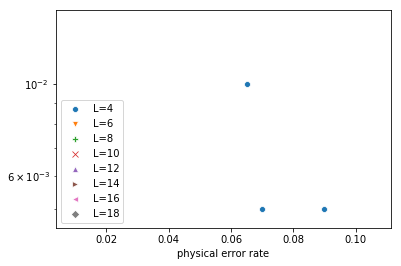

In [0]:
#Plot of the unflagged logical error rate
L = np.arange(4,12,2)
sns.scatterplot(perr,UFLER[0],label = 'L=4',marker = 'o')
sns.scatterplot(perr,UFLER[1],label = 'L=6',marker = 'v')
sns.scatterplot(perr,UFLER[2],label = 'L=8',marker = 'P')
sns.scatterplot(perr,UFLER[3],label = 'L=10',marker = 'x')
sns.scatterplot(perr,UFLER[4],label = 'L=12',marker = '^')
sns.scatterplot(perr,UFLER[5],label = 'L=14',marker = '>')
sns.scatterplot(perr,UFLER[6],label = 'L=16',marker = '<')
sns.scatterplot(perr,UFLER[7],label = 'L=18',marker = 'D')
plt.xlabel('physical error rate')
plt.yscale('log')
plt.legend(loc = 'lower left') 
plt.gca().set_ylim(4.5*10**-3,0.015)
plt.savefig('drive/My Drive/UFLER.pdf')

In [0]:
#Syndrome and error mapping, random error, saved
L=4#The dimensions of the code given by the number of plaquettes
p_err = 0.01#The probability of having an error
code, codeX,codeZ,syndromeX,syndromeZ = initial(L)
error_list = ['X','Y','Z']
print('Errorless code')
print(code)
savedcodeX = []
savedcodeZ = []
savedsyndromeX = []
savedsyndromeZ = []
for num in range(300):
    code, codeX,codeZ,syndromeX,syndromeZ = initial(L)
    for error in range(3):#For each type of error we generate random numbers to see if that qubit has that type of error or not
        for i in range(4):#For each qubit, we generate a random number, which if its smaller than p_err, we assign an error on that qubit
            for j in range(4):
                if code[i,j]!=0:
                    prob = random.random()
                    if prob <= p_err:
                        codeX,codeZ,syndromeX,syndromeZ=applyerror(codeX,codeZ,syndromeX,syndromeZ,i,j,error_list[error])
    savedcodeX.append(codeX)
    savedcodeZ.append(codeZ)
    savedsyndromeX.append(syndromeX)
    savedsyndromeZ.append(syndromeZ)
np.savez('drive/My Drive/examples.npz',codeX = savedcodeX, codeZ = savedcodeZ, syndromeX = savedsyndromeX, syndromeZ = savedsyndromeZ)
Check = np.load('drive/My Drive/examples.npz')
SX = Check['syndromeX']
SZ = Check['syndromeZ']
CX = Check['codeX']
CZ = Check['codeZ']
print('Code X')  
print(codeX)
print('Syndrome X')
print(syndromeX)
print('Code Z')
print(codeZ)
print('Syndrome Z')
print(syndromeZ)
CX = 0.5-0.5*CX
CZ = 0.5-0.5*CZ
trainX = []
trainZ = []
for i in range(len(SX)):
  trainX.append((SX[i],CZ[i]))
  trainZ.append((SZ[i],CX[i]))

Errorless code
[[0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]]
Code X
[[0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]]
Syndrome X
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
Code Z
[[0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]]
Syndrome Z
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]


In [0]:
#Neural belief propagation training
L = 4
cycles = 12
p_err = 0.01
num_weights = []
filepath = 'drive/My Drive/weightbias4Z.npz'
for i in range(cycles):
    num_weights.append(4*(L**2))
# NBP = Network(num_weights,data = filepath)#Used when we want to retrain the network
NBP = Network(num_weights) #Used when we want to train the network from the
#beginning
NBP.SGD(trainZ, 10, 30, 0.0001,p_err,'Z',filepath,test_data=None)


Epoch 0 complete
Epoch 1 complete
Epoch 2 complete
Epoch 3 complete
Epoch 4 complete
Epoch 5 complete
Epoch 6 complete
Epoch 7 complete
Epoch 8 complete
Epoch 9 complete


In [0]:
#This cell is used to load a training set of data
Check = np.load('drive/My Drive/examples.npz')

SX = Check['syndromeX']
SZ = Check['syndromeZ']
CX = Check['codeX']
CZ = Check['codeZ']
print CX[1]
CX = 0.5-0.5*CX
CZ = 0.5-0.5*CZ
print CX[1]
trainX = []
trainZ = []
for i in range(len(SX)):
  trainX.append((SX[i],CZ[i]))
  trainZ.append((SZ[i],CX[i]))

[[ 0.  1.  0.  1.  0.  1.  0.  1.]
 [ 1.  0.  1.  0.  1.  0.  1.  0.]
 [ 0.  1.  0.  1.  0.  1.  0.  1.]
 [-1.  0.  1.  0.  1.  0.  1.  0.]
 [ 0.  1.  0. -1.  0.  1.  0.  1.]
 [ 1.  0.  1.  0.  1.  0.  1.  0.]
 [ 0.  1.  0.  1.  0.  1.  0.  1.]
 [ 1.  0.  1.  0.  1.  0.  1.  0.]]
[[0.5 0.  0.5 0.  0.5 0.  0.5 0. ]
 [0.  0.5 0.  0.5 0.  0.5 0.  0.5]
 [0.5 0.  0.5 0.  0.5 0.  0.5 0. ]
 [1.  0.5 0.  0.5 0.  0.5 0.  0.5]
 [0.5 0.  0.5 1.  0.5 0.  0.5 0. ]
 [0.  0.5 0.  0.5 0.  0.5 0.  0.5]
 [0.5 0.  0.5 0.  0.5 0.  0.5 0. ]
 [0.  0.5 0.  0.5 0.  0.5 0.  0.5]]
